<img src="https://devra.ai/analyst/notebook/3389/image.jpg" style="width: 100%; height: auto;" />

<div style="text-align:center; border-radius:15px; padding:15px; color:white; margin:0; font-family: 'Orbitron', sans-serif; background: #2E0249; background: #11001C; box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.3); overflow:hidden; margin-bottom: 1em;">    <div style="font-size:150%; color:#FEE100"><b>Power Line Fault Simulation Analysis</b></div>    <div>This notebook was created with the help of <a href="https://devra.ai/ref/kaggle" style="color:#6666FF">Devra AI</a></div></div>

## Table of Contents

- [Introduction](#Introduction)
- [Data Loading and Overview](#Data-Loading-and-Overview)
- [Data Cleaning and Preprocessing](#Data-Cleaning-and-Preprocessing)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Predictive Modeling](#Predictive-Modeling)
- [Conclusion and Future Work](#Conclusion-and-Future-Work)

## Introduction

In this notebook we explore a simulated dataset related to power line faults. There is something quite fascinating about how simulated sensor data can forecast real-life system faults. If you find this analysis interesting or useful, consider upvoting it.

Our journey will begin with a thorough look at the dataset before diving into cleaning, exploratory analysis, and finally building a predictive model for fault classification. Enjoy the ride (and the occasional wry comment).

In [1]:
# Importing libraries and suppressing warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib
matplotlib.use('Agg')  # Ensure compatibility for script-based plotting
import matplotlib.pyplot as plt
plt.switch_backend('Agg')  # In case only plt is imported from matplotlib
%matplotlib inline

import seaborn as sns

# Some sklearn imports for predictive modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.inspection import permutation_importance

# Setting a seaborn style for the plots
sns.set(style='whitegrid')

# Dry humor: We import enough libraries to make a chemist jealous.

## Data Loading and Overview

We will load the merged dataset which contains several measurements along with the fault labels. If there are any issues with file paths or encodings, note that specifying delimiter and encoding correctly can save you from many headaches (as many others have painfully learned).

In [2]:
# Load the merged dataset
try:
    df = pd.read_csv('/kaggle/input/power-line-fault-simulation-data/merged_dataset.csv', delimiter=',', encoding='ascii')
except Exception as e:
    print(f"Error loading file: {e}")

# Display first few rows and dataset info
print("Data Loaded Successfully. First few rows:")
display(df.head())

print("Dataframe Information:")
print(df.info())

print("Statistical Summary:")
display(df.describe())

Data Loaded Successfully. First few rows:


,t,Va,Vb,Vc,Ia,Ib,Ic,Fault
0,0.0000,123.673155,-318.714610,195.041455,3827.709068,-9954.681312,6126.972245,0
1,0.0001,132.928422,-319.851525,186.923103,4117.440004,-9991.463731,5874.023726,0
2,0.0002,142.052661,-320.672826,178.620166,4403.112401,-10018.387070,5615.274666,0
3,0.0003,151.036833,-321.177694,170.140861,4684.443276,-10035.424470,5350.981195,0
4,0.0004,159.872046,-321.365624,161.493578,4961.154162,-10042.558910,5081.404750,0


Dataframe Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16004 entries, 0 to 16003
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   t       16004 non-null  float64
 1   Va      16004 non-null  float64
 2   Vb      16004 non-null  float64
 3   Vc      16004 non-null  float64
 4   Ia      16004 non-null  float64
 5   Ib      16004 non-null  float64
 6   Ic      16004 non-null  float64
 7   Fault   16004 non-null  int64  
dtypes: float64(7), int64(1)
memory usage: 1000.4 KB
None
Statistical Summary:


,t,Va,Vb,Vc,Ia,Ib,Ic,Fault
count,16004.000000,16004.000000,16004.000000,16004.000000,16004.000000,16004.000000,16004.000000,16004.000000
mean,0.200000,0.843025,0.074239,-0.774321,811.617302,80.453805,-892.071107,0.750187
std,0.115503,185.158509,228.305732,214.337091,25806.937879,20084.270608,27068.159572,1.089830
min,0.000000,-321.337862,-399.758521,-439.906216,-75450.670310,-75452.398310,-101459.969000,0.000000
25%,0.100000,-132.925858,-211.819511,-165.674065,-8867.564064,-8165.421349,-8931.921277,0.000000
50%,0.200000,2.755851,0.236431,-2.427893,174.618721,69.461964,-279.759159,0.000000
75%,0.300000,132.925860,211.819511,170.141151,9026.111438,8165.421349,8662.374220,2.000000
max,0.400000,321.337865,399.792289,440.461693,104412.724800,78820.581670,75455.416660,3.000000


## Data Cleaning and Preprocessing

Before getting into the exploratory visualizations, it's essential to confirm that our data is free from missing values and duplicates. We also check that the data types associated with each column are correct. Note that while the column 't' is a number, it acts as a simulation time marker and is not a traditional date; however, if you encounter date columns in other datasets, convert them accordingly.

In [3]:
# Checking for missing values
missing_values = df.isnull().sum()
print("Missing Values in each column:")
print(missing_values)

# Checking for duplicate rows
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

# If needed, drop duplicates (uncomment the line below if you're sure)
# df.drop_duplicates(inplace=True)

Missing Values in each column:
t        0
Va       0
Vb       0
Vc       0
Ia       0
Ib       0
Ic       0
Fault    0
dtype: int64
Number of duplicate rows: 4000


## Exploratory Data Analysis

Let's visualize the data to uncover hidden patterns, correlations and the distribution of our fault labels. We will be using various visualization techniques that include heatmaps, pair plots, histograms, and more. After all, why just crunch numbers when you can also impress with beautiful charts?

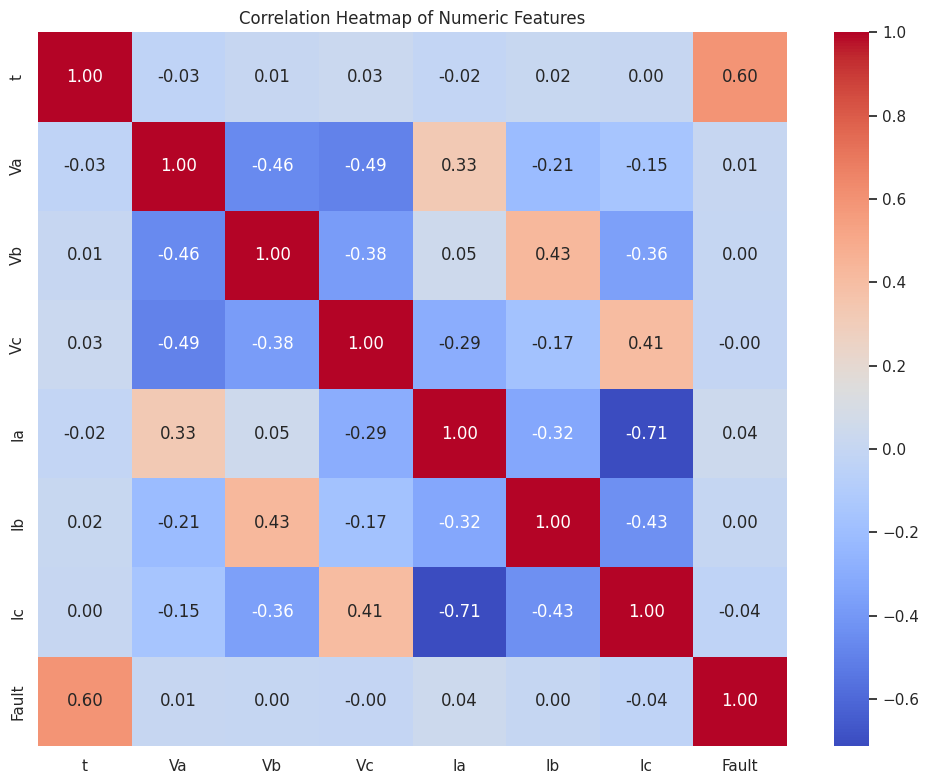

In [4]:
# Reduce the dataframe to only numeric values for the correlation heatmap
numeric_df = df.select_dtypes(include=[np.number])

# Ensure that there are at least 4 numeric columns before plotting
if len(numeric_df.columns) >= 4:
    plt.figure(figsize=(10, 8))
    sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap of Numeric Features')
    plt.tight_layout()
    plt.show()
else:
    print("Not enough numeric columns for a correlation heatmap.")

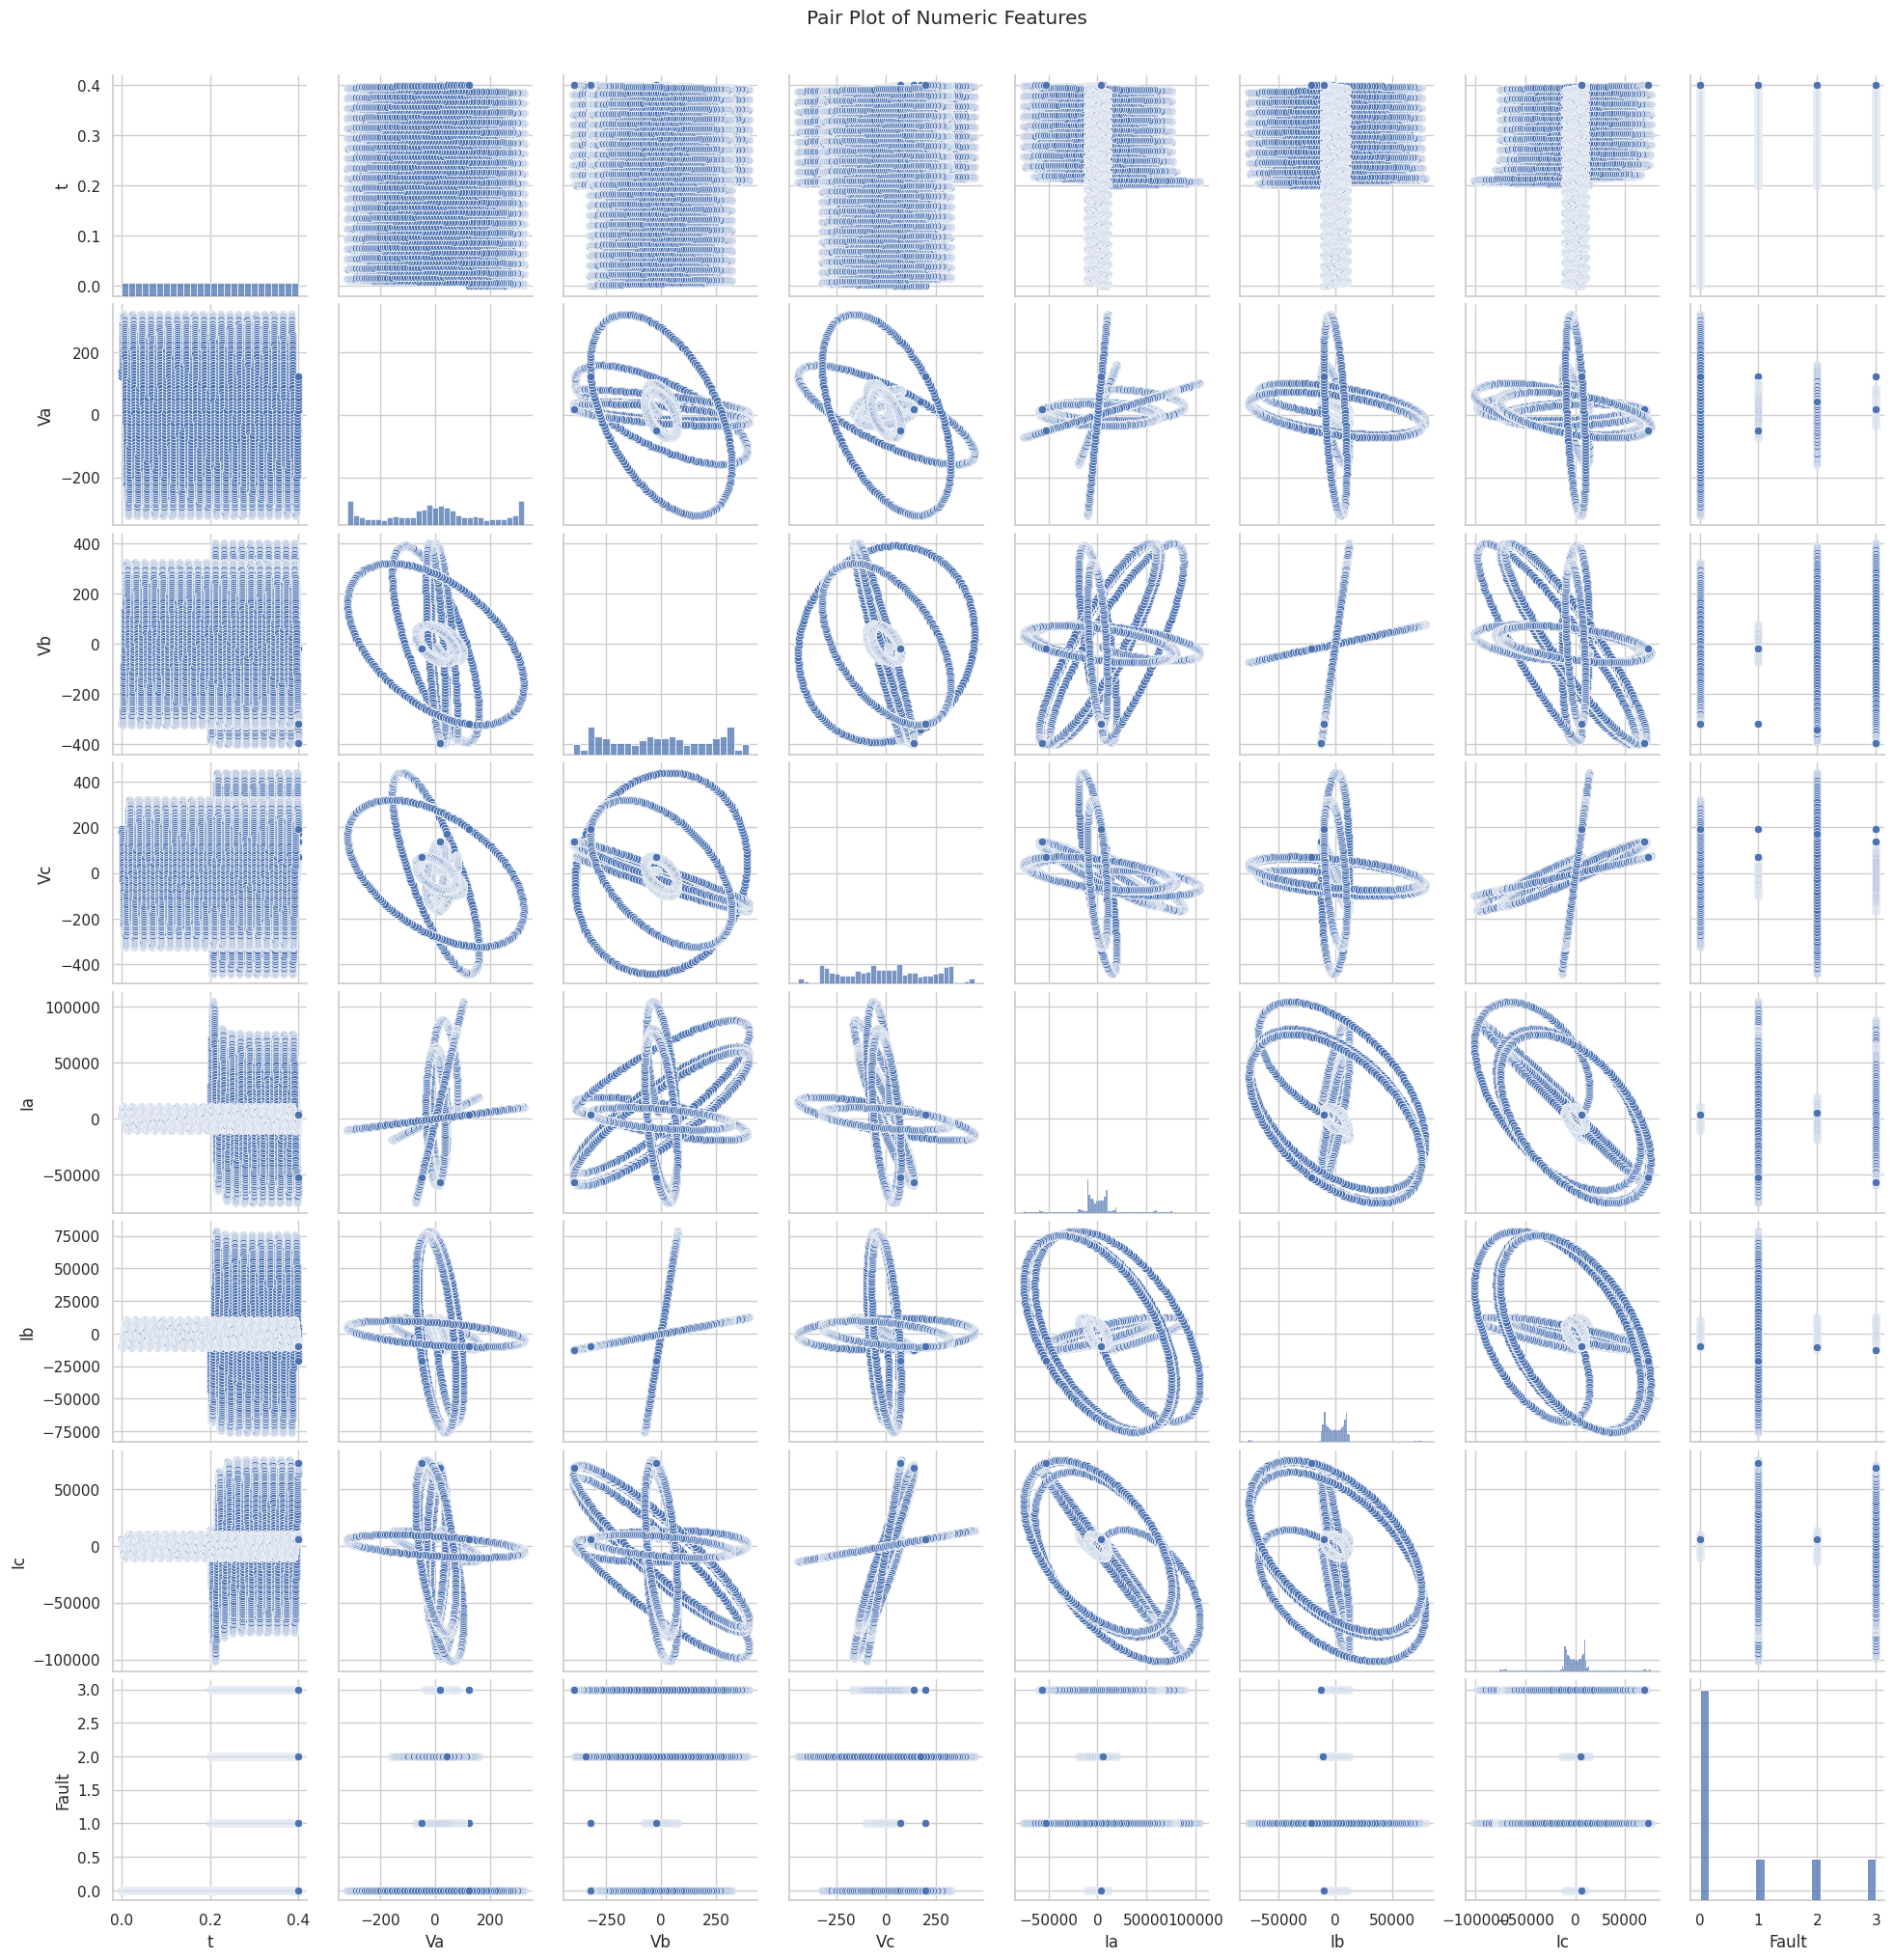

In [5]:
# Generate a pair plot for the numeric features
sns.pairplot(numeric_df)
plt.suptitle('Pair Plot of Numeric Features', y=1.02)
plt.show()

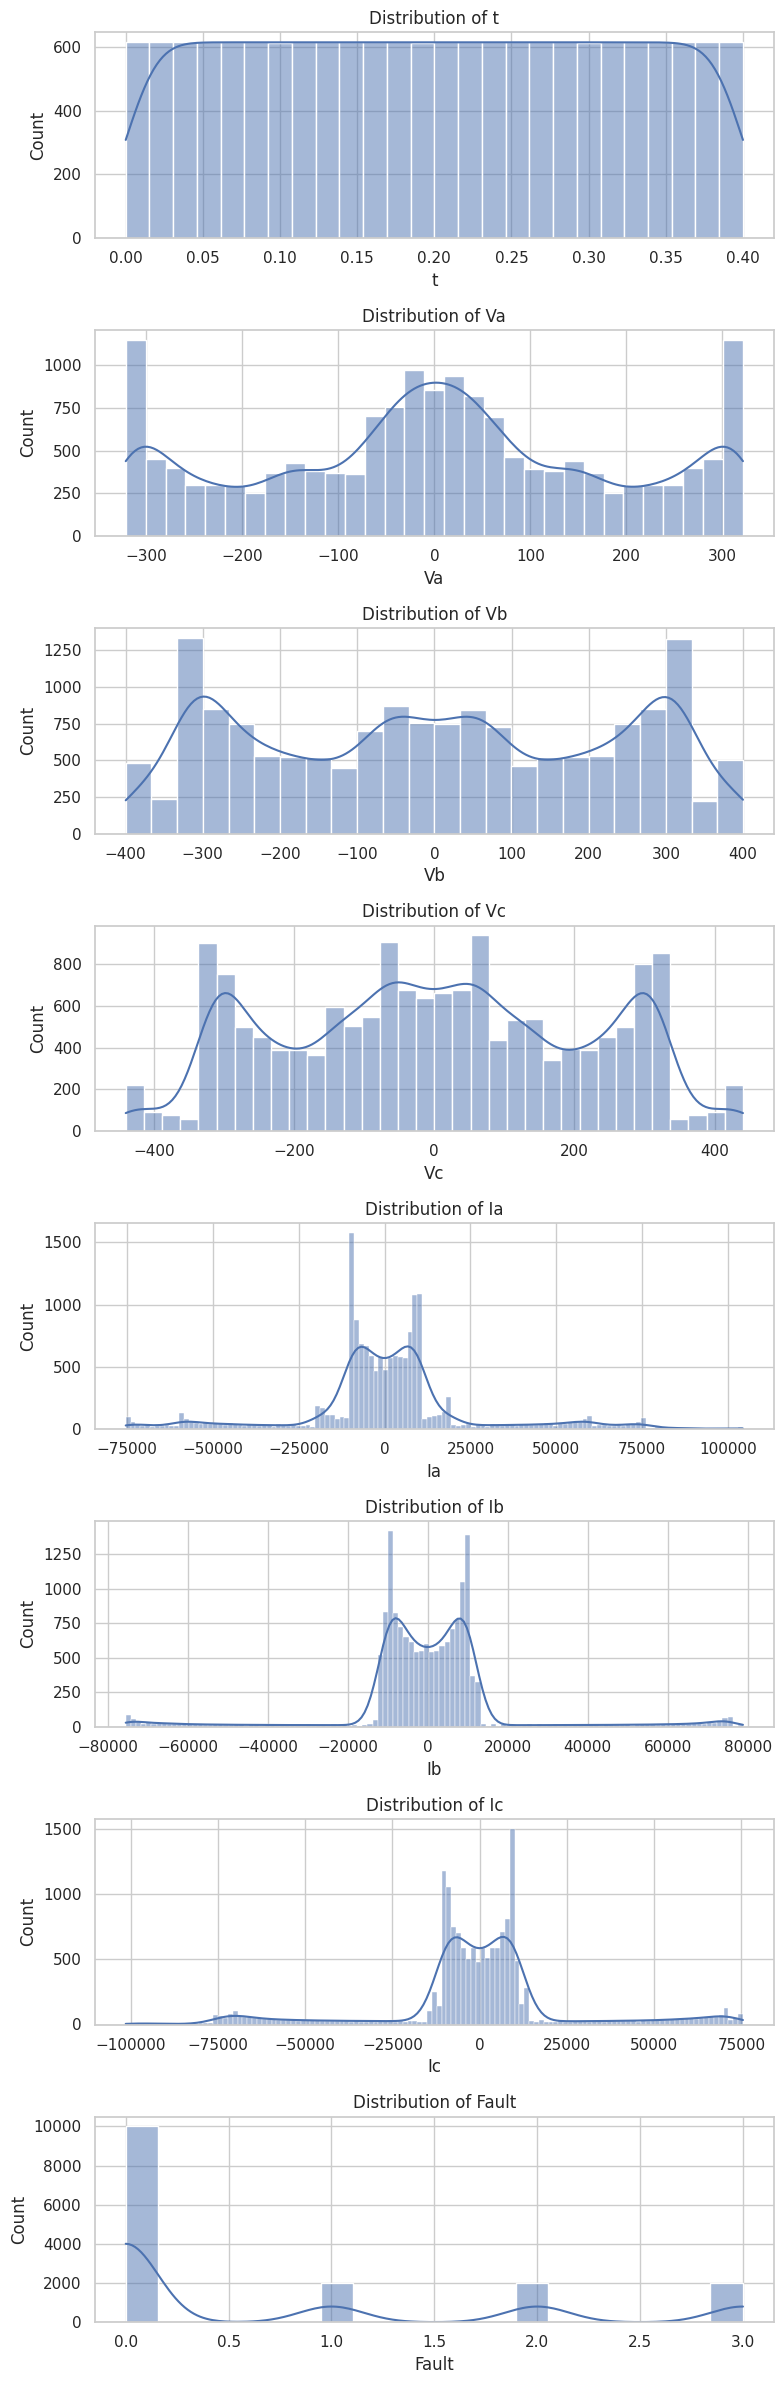

In [6]:
# Plot histograms for each column using seaborn's histplot
numeric_columns = numeric_df.columns.tolist()

fig, axes = plt.subplots(nrows=len(numeric_columns), ncols=1, figsize=(8, 3 * len(numeric_columns)))

for ax, col in zip(axes, numeric_columns):
    sns.histplot(df[col], kde=True, ax=ax)
    ax.set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

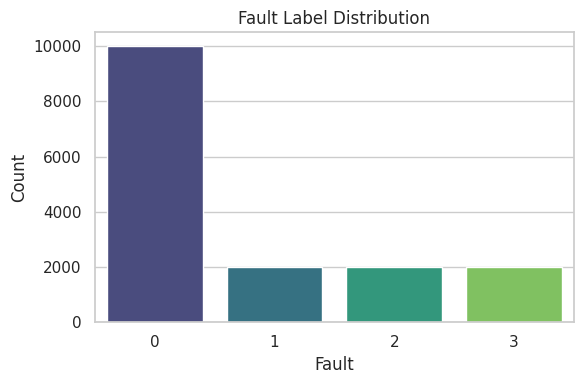

In [7]:
# Visualize the distribution of the 'Fault' column
plt.figure(figsize=(6, 4))
sns.countplot(x='Fault', data=df, palette='viridis')
plt.title('Fault Label Distribution')
plt.xlabel('Fault')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## Predictive Modeling

Now that we have explored the dataset, we attempt to build a predictor for fault classification. The idea is to use sensor readings to predict whether there is a fault or not. We use a simple logistic regression model here. In a production scenario, you might want to try more sophisticated ensemble methods. Remember, a model is only as good as the data (and your coffee intake)!

In [8]:
# Prepare the feature matrix and target vector
features = ['t', 'Va', 'Vb', 'Vc', 'Ia', 'Ib', 'Ic']
target = 'Fault'

X = df[features]
y = df[target]

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

print("Logistic Regression model trained successfully")

Logistic Regression model trained successfully


Prediction Accuracy: 0.6279


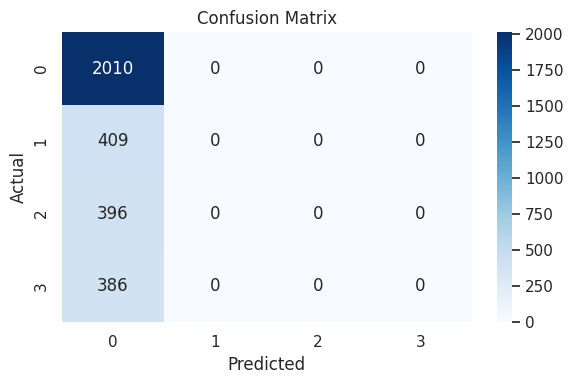

ROC Curve is applicable only for binary classification.


In [9]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate prediction accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Prediction Accuracy: {accuracy:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# ROC Curve (assumes binary classification for Fault)
if len(np.unique(y)) == 2:
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()
else:
    print("ROC Curve is applicable only for binary classification.")

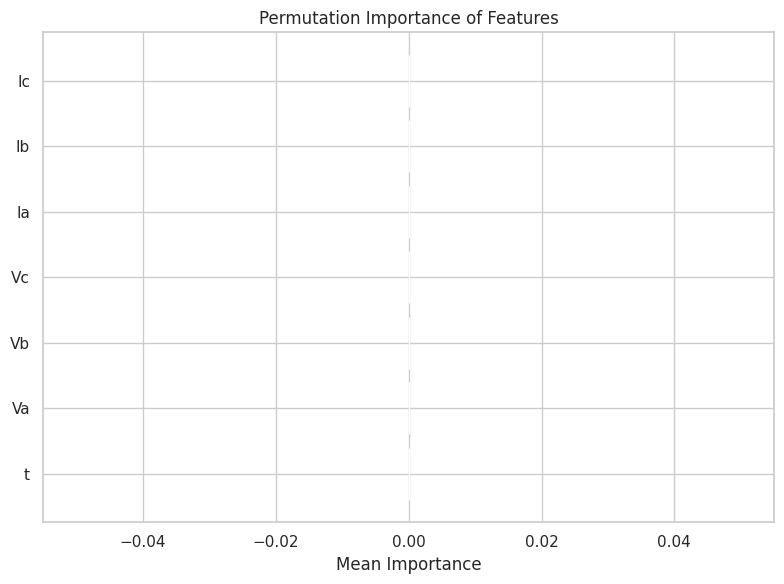

In [10]:
# Calculate permutation importance to further evaluate our model
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

# Create a dataframe for permutation importance
perm_df = pd.DataFrame({'feature': features, 'importance': perm_importance.importances_mean})
perm_df = perm_df.sort_values(by='importance', ascending=True)

# Plot permutation importance using a horizontal bar plot
plt.figure(figsize=(8, 6))
plt.barh(perm_df['feature'], perm_df['importance'], color='teal')
plt.xlabel('Mean Importance')
plt.title('Permutation Importance of Features')
plt.tight_layout()
plt.show()

## Conclusion and Future Work

We have successfully loaded, cleaned, and explored our power line fault simulation dataset. Through exploratory data visualizations, we unearthed notable patterns in the sensor measurements. Our logistic regression model, albeit simple, provided a baseline prediction accuracy along with insights via confusion matrix and ROC analysis.

Future analysis could involve:

- Trying more robust models such as Random Forests or Gradient Boosted Trees to improve prediction accuracy.
- Implementing advanced feature engineering to capture non-linear interactions in sensor data.
- Conducting time series analysis if the simulation time (column 't') shows sequential dependencies.

If you enjoyed this notebook, please consider upvoting it. Happy analyzing!